In [2]:
import tensorflow as tf

In [4]:
import pandas as pd

In [16]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
import pandas as pd
import os

In [6]:
lung_aca = '/content/drive/MyDrive/lung_colon_image_set/lung_image_sets/lung_aca'
lung_n = '/content/drive/MyDrive/lung_colon_image_set/lung_image_sets/lung_n'
lung_scc = '/content/drive/MyDrive/lung_colon_image_set/lung_image_sets/lung_scc'

In [7]:
# Create lists to hold image paths and labels
image_paths = []
labels = []

# Function to add images from a directory to the lists
def add_images_from_directory(directory, label):
    if not os.path.exists(directory):
        print(f"Directory does not exist: {directory}")
        return
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpeg', '.jpg', '.png')):  # Check for image files
            image_paths.append(os.path.join(directory, filename))
            labels.append(label)

# Add images from each directory
add_images_from_directory(lung_aca, 'Lung_adenocarcinoma')
add_images_from_directory(lung_n, 'Lung_benign_tissue')
add_images_from_directory(lung_scc, 'Lung_squamous_cell_carcinoma')

# Create a DataFrame with all image paths and labels
df = pd.DataFrame({
    'path': image_paths,
    'label': labels
})

# Display the shape of the DataFrame
print(df.shape)
print(df.head())

(15020, 2)
                                                path                label
0  /content/drive/MyDrive/lung_colon_image_set/lu...  Lung_adenocarcinoma
1  /content/drive/MyDrive/lung_colon_image_set/lu...  Lung_adenocarcinoma
2  /content/drive/MyDrive/lung_colon_image_set/lu...  Lung_adenocarcinoma
3  /content/drive/MyDrive/lung_colon_image_set/lu...  Lung_adenocarcinoma
4  /content/drive/MyDrive/lung_colon_image_set/lu...  Lung_adenocarcinoma


In [8]:
df.columns

Index(['path', 'label'], dtype='object')

In [9]:
df['label'].unique()

array(['Lung_adenocarcinoma', 'Lung_benign_tissue',
       'Lung_squamous_cell_carcinoma'], dtype=object)

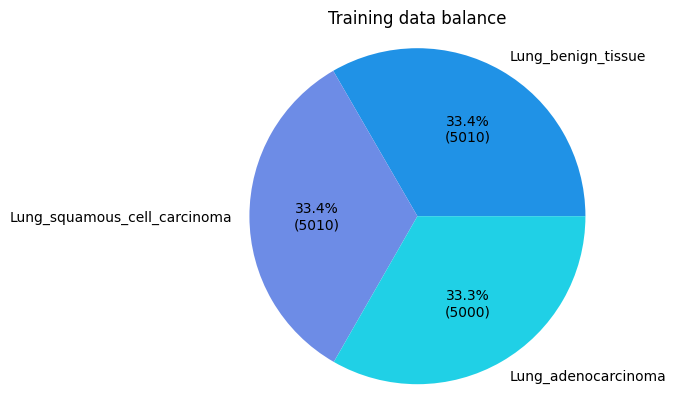

In [10]:
import matplotlib.pyplot as plt
data_balance = df.label.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
train_df,ts_df = train_test_split(df,test_size=0.8,shuffle=True,random_state=True)
valid_df,test_df = train_test_split(ts_df,test_size=0.5,shuffle=True,random_state=True)

In [12]:
train_df.shape, valid_df.shape, test_df.shape

((3004, 2), (6008, 2), (6008, 2))

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adamax,Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.applications import EfficientNetB3

In [14]:
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale = 1. / 255)
ts_gen = ImageDataGenerator(rescale = 1. / 255)

train_gen = tr_gen.flow_from_dataframe(train_df,x_col='path',y_col='label',
                                       target_size=img_size,batch_size=batch_size,class_mode='categorical',
                                       color_mode='rgb',shuffle=True)
valid_gen = ts_gen.flow_from_dataframe(valid_df,x_col='path',y_col='label',
                                       target_size=img_size,batch_size=batch_size,class_mode='categorical',
                                       color_mode='rgb',shuffle=True)
test_gen = ts_gen.flow_from_dataframe(test_df,x_col='path',y_col='label',
                                       target_size=img_size,batch_size=batch_size,class_mode='categorical',
                                       color_mode='rgb',shuffle=True)

Found 3004 validated image filenames belonging to 3 classes.
Found 6008 validated image filenames belonging to 3 classes.
Found 6008 validated image filenames belonging to 3 classes.


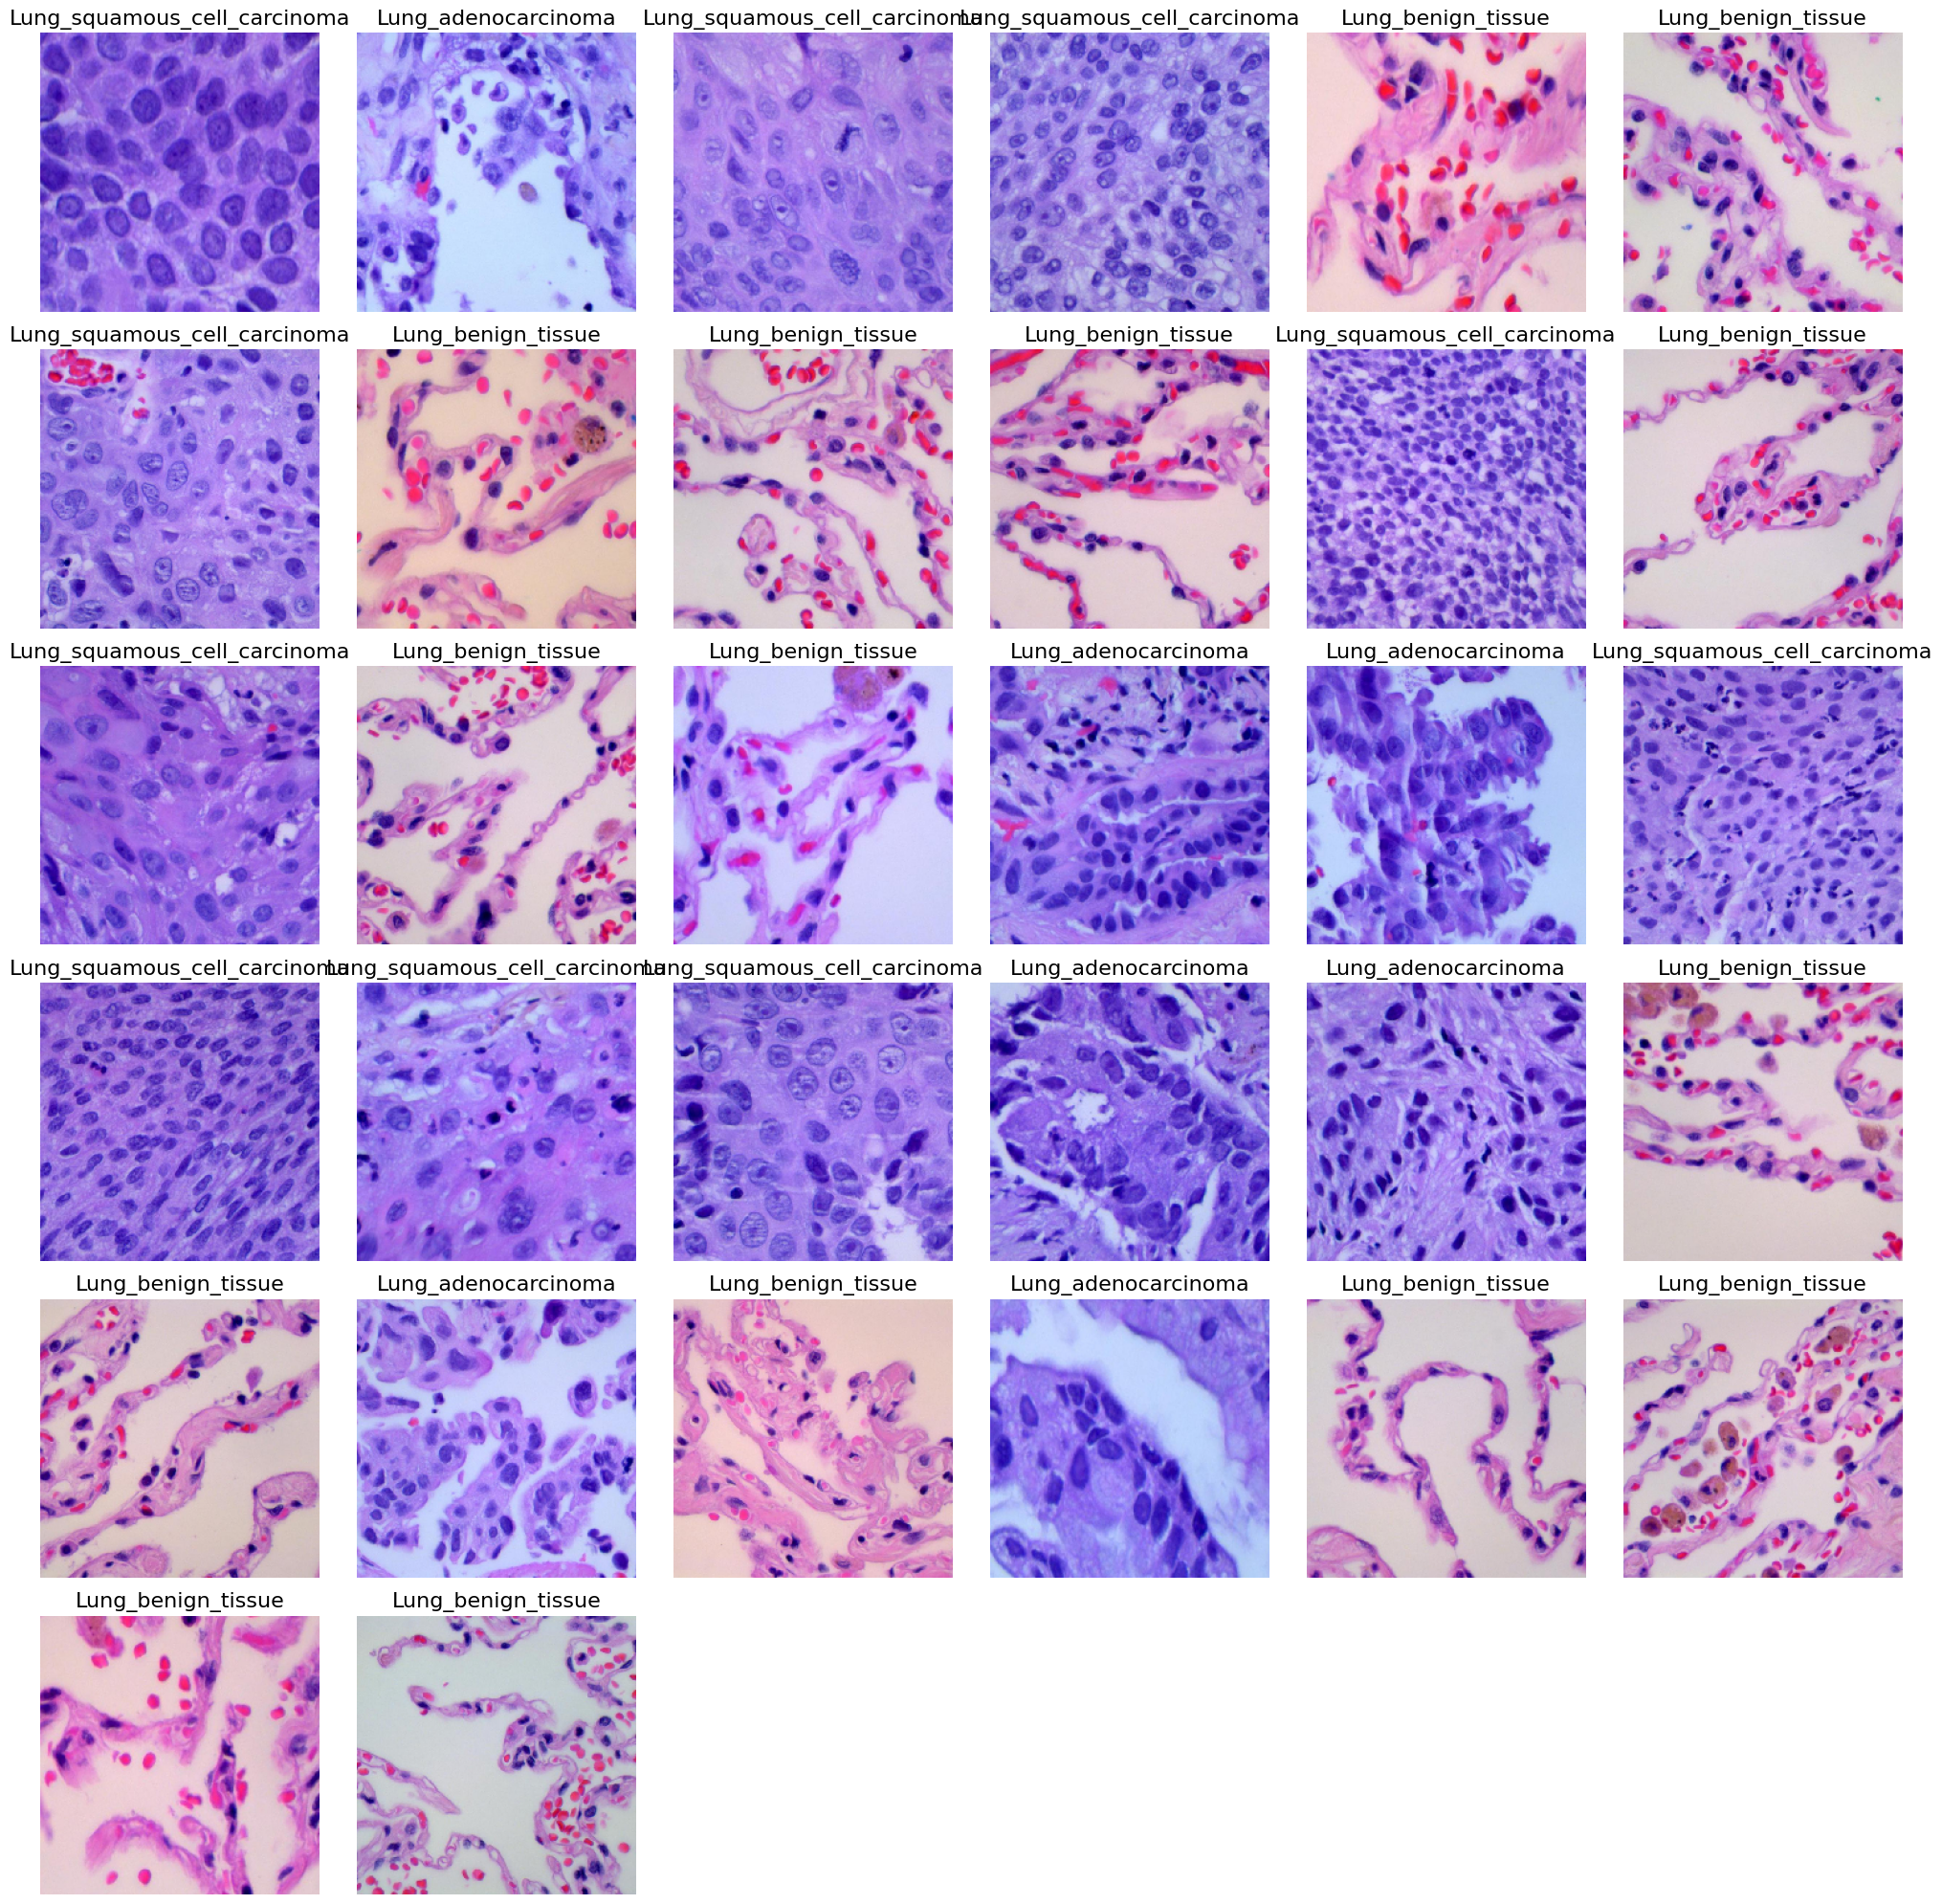

In [17]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:
# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):

    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block



In [19]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))

In [20]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet',
                            include_top=False,
                            input_shape = img_shape,
                            pooling=None)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation

# the model
ResNet50_model = Model(inputs = base_model.input, outputs = predictions)

In [21]:
ResNet50_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
epochs = 20
history = ResNet50_model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    shuffle=False
)

# Save the model correctly
ResNet50_model.save("lung_cancer_classifier_model.h5")

print("Model saved successfully as 'lung_cancer_classifier_model.h5'")


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 71s 759ms/step - accuracy: 0.9994 - loss: 0.0146 - val_accuracy: 0.9937 - val_loss: 0.0288
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 72s 762ms/step - accuracy: 0.9997 - loss: 0.0142 - val_accuracy: 0.9938 - val_loss: 0.0262
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 71s 757ms/step - accuracy: 0.9994 - loss: 0.0129 - val_accuracy: 0.9928 - val_loss: 0.0279
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 71s 762ms/step - accuracy: 0.9999 - loss: 0.0121 - val_accuracy: 0.9942 - val_loss: 0.0247
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 749ms/step - accuracy: 0.9998 - loss: 0.0107 - val_accuracy: 0.9945 - val_loss: 0.0257
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 71s 759ms/step - accuracy: 0.9988 - loss: 0.0117 - val_accuracy: 0.9920 - val_loss: 0.0253
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 71s 754ms/step - accuracy: 0.9988 - loss: 0.0120 - val_accuracy: 0.9933 - val_loss: 0.0232
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 71s 759ms/step - accuracy: 0.9997 - loss: 0.0125 - val_accu

Model saved successfully as 'lung_cancer_classifier_model.h5'


In [1]:
import psutil
print(f"Available Memory: {psutil.virtual_memory().available / (1024**3):.2f} GB")


Available Memory: 10.92 GB


In [3]:
import gc
gc.collect()


40

In [31]:
from sklearn.metrics import  confusion_matrix
from itertools import product
import itertools

In [25]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):

    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [26]:
# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

# Get Predictions
def get_pred(model, test_gen):

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)

    return y_pred



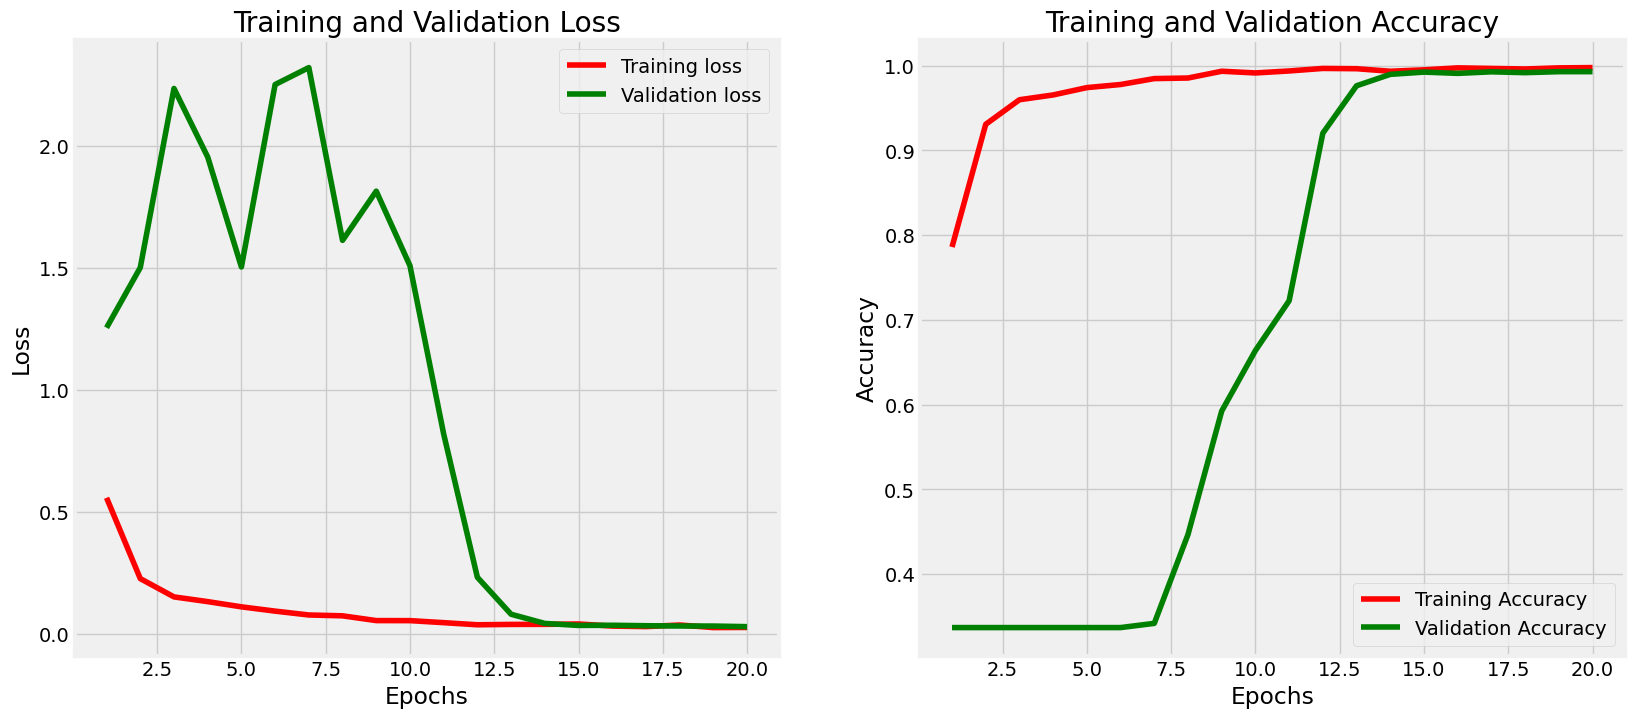

In [24]:
# Display model performance
model_performance(model, epochs)


In [27]:
# Model evaluation
model_evaluation(ResNet50_model)

94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 246ms/step - accuracy: 1.0000 - loss: 0.0035
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 221ms/step - accuracy: 0.9931 - loss: 0.0285


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 233ms/step - accuracy: 0.9883 - loss: 0.0398
Train Loss:  0.0035009696148335934
Train Accuracy:  1.0
--------------------
Validation Loss:  0.028475003316998482
Validation Accuracy:  0.9928428530693054
--------------------
Test Loss:  0.03619224205613136
Test Accuracy:  0.9881824254989624


188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 220ms/step


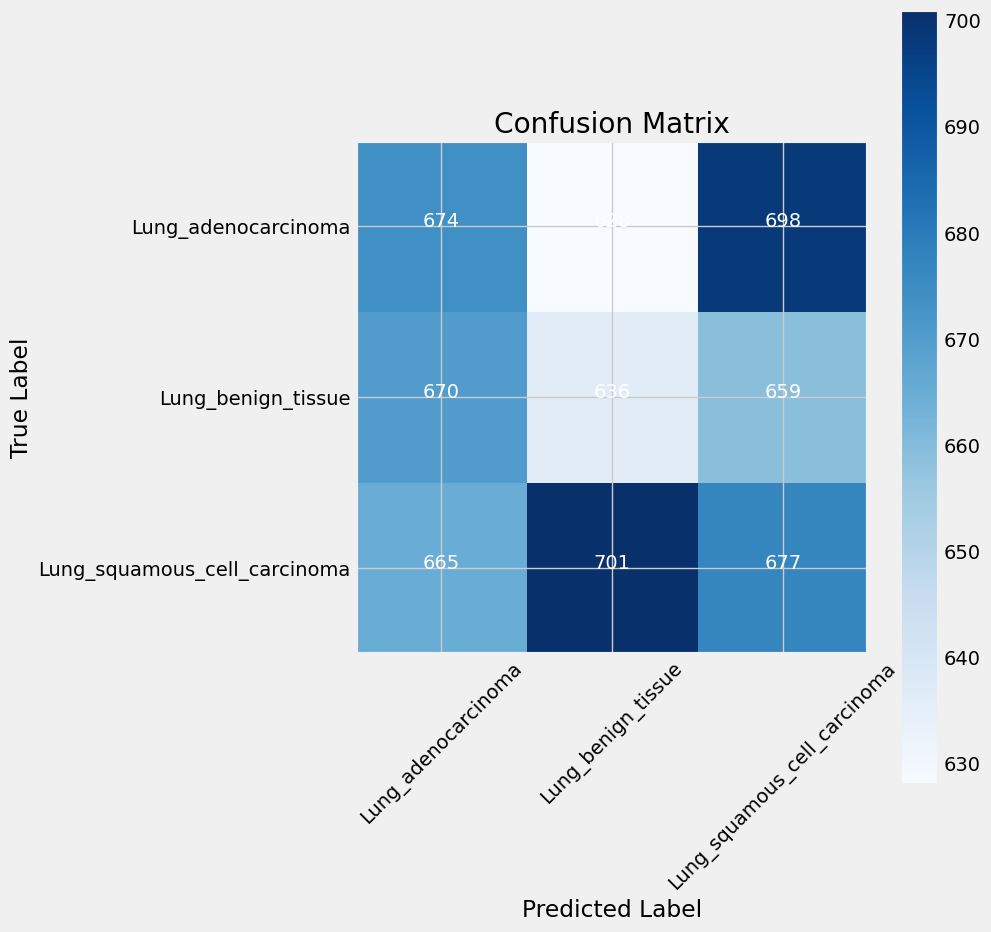

In [32]:
# get predictions
y_pred = get_pred(ResNet50_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)